# Multigraph Representation Learning

Say you're a brain researcher, and you have a bunch of scans of people's brains - some are scans of normal people, and some are scans of people with Abnormal Disease. You have an algorithm that lets you create networks from these brains, so you turn all your brain scans into networks. You want to know if these two different types of networks share a common community structure. It seems like you should be able to find communities in both networks -- they're both brain networks, after all -- but what do you do? How do you even deal with situations in which you have a lot of networks whose nodes all represent the same objects, but which might come from quite different distributions?

Well, if your goal is to find the shared community structure between the normal and abnormal networks, you could try embedding your networks and then seeing those embeddings look like. This would serve the dual purpose of having less stuff to deal with and having some way to directly compare your networks in the same space. For example, say you have nine networks of normal brains and nine networks of abnormal brains.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from graspologic.simulations import sbm

# Generate networks from an SBM, given some parameters
def make_network(*probs, n=100, return_labels=False):
    p1, p2, p3, p4 = probs
    P = np.array([[p1, p2], 
                  [p3, p4]])
    
    return sbm([n, n], P, return_labels=return_labels)

# make nine normal networks
# and nine abnormal networks
p1, p2, p3 = .12, .06, .03
n = 100
labels = [0]*n + [1]*n
normals = [make_network(p1, p3, p3, p1, n=n) for i in range(9)]
abnormals = [make_network(p3, p1, p1, p3, n=n) for i in range(9)]

The normal brains are all drawn from the same distribution, and the abnormal brains are also all drawn from the same distribution. We're using Stochastic Block models to model both types of brain networks. However, if you look at the code, you'll see that the normal brains were set up to have strong connections within communities, whereas the abnormal brains were set up to have strong connections between communities. Below is a plot of the adjacency networks for every normal and every abnormal brain we've created.

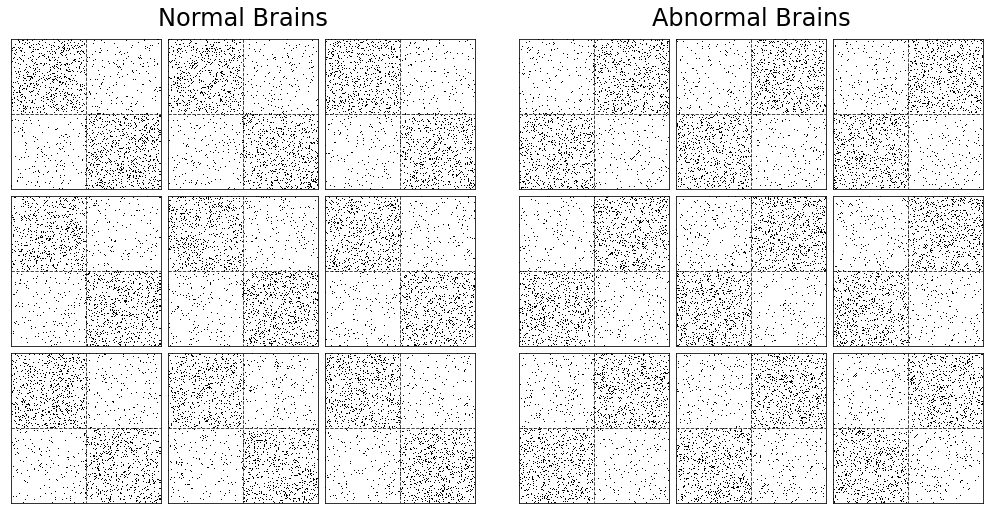

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from graspologic.plot import binary_heatmap, adjplot

fig = plt.figure(figsize=(14,7))

grid1 = ImageGrid(fig, 121, (3, 3), axes_pad=.1, share_all=True)
grid2 = ImageGrid(fig, 122, (3, 3), axes_pad=.1, share_all=True)

for i, (axi, axj) in enumerate(zip(grid1, grid2)):
    hmn = binary_heatmap(normals[i], ax=axi, cbar=False)
    hma = binary_heatmap(abnormals[i], ax=axj, cbar=False)
    for ax in [hmn, hma]:
        for spine in ax.spines.values():
            spine.set_visible(True)    
        ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
        ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

grid1.axes_all[1].set_title("Normal Brains", fontsize=24, y=1.05)
grid2.axes_all[1].set_title("Abnormal Brains", fontsize=24, y=1.05)

plt.tight_layout(w_pad=3)

Remember, our goal is to find the community structure in these brains. We'd like to embed our brain networks into some lower-dimensional space to see if we can see this more clearly. Then, we'll see whether we can find some clustering in that space. Try to think about how you might find a lower-dimensional embedding where the location of each node's latent positions uses information from all of the networks.

The first thing you might come up with is to average your networks together, and then embed the result of that averaging. It turns out that this is actually the right thing to do in the special case where every network you average comes from the same distribution. In our case, averaging only the normal networks together, and averaging only the abnormal networks together, will produce two separate embeddings with nicely clustered nodes.

In [4]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

# Compute the average adjacency matrix for 
# normal brains and alzheimer's brains
normal_mean = np.array(normals).mean(axis=0)
abnormal_mean = np.array(abnormals).mean(axis=0)

# Embed both matrices
ase = ASE(n_components=2)
latents_normal = ase.fit_transform(normal_mean)
latents_abnormal = ase.fit_transform(abnormal_mean)

The below plot shows what happens when we embed the averaged normal and abnormal networks separately. Like all of our embedding plots, each dot represents the latent positions for a particular node.

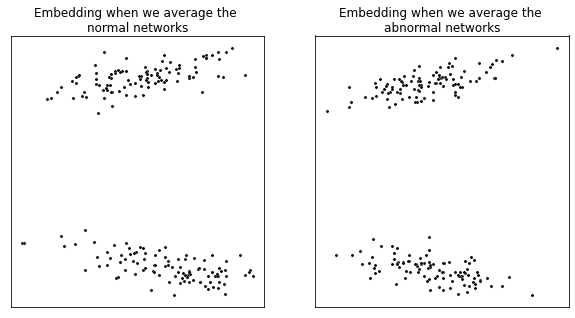

In [5]:
import seaborn as sns

def plot_latents(latent_positions, *, title=None, labels=None, ax=None, legend=False,
                 fontdict=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           s=10, ax=ax, palette="Set1", color='k', **kwargs)
    if title is not None:
        plot.set_title(title, wrap=True, fontdict=fontdict);
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    if legend:
        ax.legend(loc="upper right", title="Community")
    elif not legend and np.any(labels):
        ax.get_legend().remove()
    
    return plot

# plot
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
plot_latents(latents_normal, title="Embedding when we average the \nnormal networks", ax=axs[0]);
plot_latents(latents_abnormal, title="Embedding when we average the \nabnormal networks", ax=axs[1]);

Both of these embeddings have clear clustering: there are two communities of nodes in both the normal and the abnormal graphs. We can recover the labels for these communities fairly easily using our pick of unsupervised clustering algorithm. Because we know that the latent positions in an Adjacency Spectral Embedding are normally distributed, we know that the above embeddings are distributed according to a Gaussian Mixture. "Gaussian" just means "normal", and a gaussian mixture model just means that we have groups of normally distributed data clusters. As a result, it makes sense to cluster these data using scikit-learn's GaussianMixture implementation.

In [6]:
from sklearn.mixture import GaussianMixture as GMM
from graspologic.utils import remap_labels

# Predict labels for the normal and abnormal brains
labels_normal = GMM(n_components=2).fit_predict(latents_normal)
labels_abnormal = GMM(n_components=2).fit_predict(latents_normal)

# Make corresponding communities have the same values
labels_abnormal = remap_labels(labels_normal, labels_abnormal)

Below is a plot showing which community we predict each community belongs to, according to our Gaussian Mixture Model.

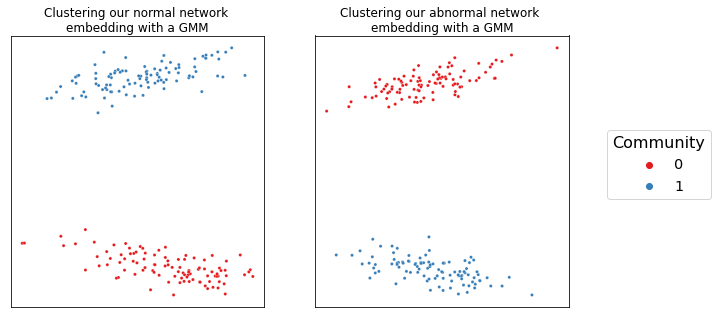

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
normal_plot_gmm = plot_latents(latents_normal, title="Clustering our normal network \nembedding with a GMM", 
             labels=labels_normal, ax=axs[0])
abnormal_plot_gmm = plot_latents(latents_abnormal, title="Clustering our abnormal network \nembedding with a GMM", 
                   labels=labels_abnormal, ax=axs[1])

plt.legend(loc=(1.15, .4), fontsize="x-large", title="Community",
           title_fontsize=16);

But what if we wanted to embed *all* of the networks into the same space, both the alzheimer's and normal networks, so that there's only one plot? Let's try it. We'll take all of the networks, both normal and abnormal ones, and then average them together, and then do an Adjacency Spectral Embedding. This will result in a single plot, with each point representing a single node. Do you think we'll still find this nice community separation?

In [8]:
total_mean = np.array(normals + abnormals).mean(axis=0)
all_latents = ase.fit_transform(total_mean)

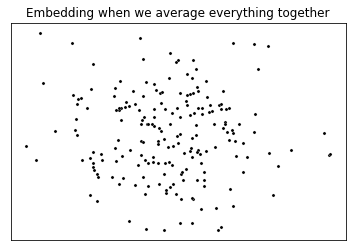

In [9]:
plot_latents(all_latents, title="Embedding when we average everything together");

Nope, bummer. Our community separation is gone. As far as anybody can tell, our latent positions have just become meaningless noise, so we can't cluster and find communities like we did before.

What we've discovered is that, even though it's a great idea to simply average a bunch of networks if they were drawn from the same distribution, it's a horrible idea to average your networks if they might come from different distributions. This is a case of averaging networks which are "heterogeneous": Not only are your networks slightly different, but they're *expected* to be different because they're distributed differently. Sampling a lot of heterogenous networks and then averaging them, as you can see above, can result in losing the community signal you might have had.

We'd like to find a way to compare these heterogeneous networks directly, so that we can embed all of our networks into the same space and still keep that community structure. Figuring out the best way to do this is a topic under active research, and the set of techniques and tools that have developed as a result are together called multigraph representation learning (here, "graph" just means "network").

## Different Types of Multigraph Representation Learning

There are at least three possible approaches to multigraph representation learning with respect to classification: Classifier Ensemble, Network Combination, and Embedding Product. Each of these eventually results in a trained classifier which tells us which nodes belong to which communities.

### Classifier Ensemble

In a Classifier Ensemble, you start with a set of networks, then you train a classifier for each network. You then have a set of classifiers, each one corresponding to one of the networks. You combine these all into a single classifier, and use this to classify all of the networks.

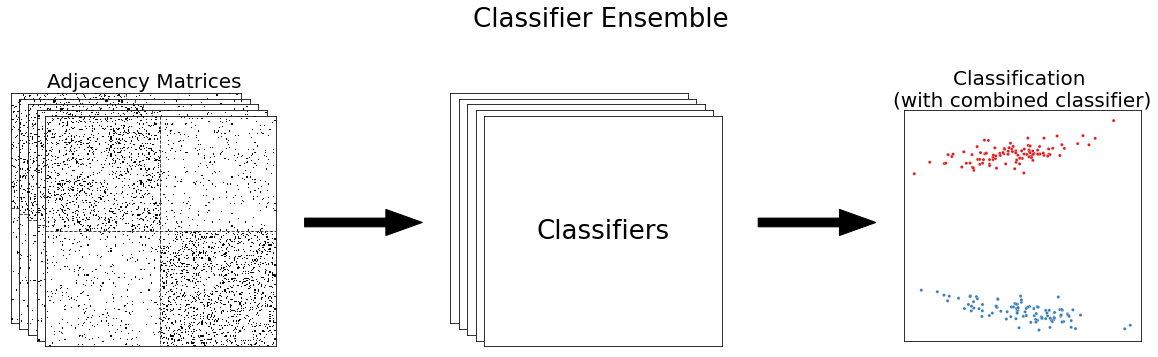

In [10]:
from graspologic.embed import MultipleASE as MASE
from graspologic.embed import OmnibusEmbed as OMNI
from graspologic.embed.omni import _get_omni_matrix
from graspologic.plot import heatmap

fig = plt.figure()

def rm_ticks(ax, **kwargs):
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    sns.despine(ax=ax, **kwargs)

# add stack of heatmaps
for i in range(5):
    ax = fig.add_axes([.02*i, -.02*i, .8, .8]) 
    ax = binary_heatmap(normals[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="right", fontsize=20)
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)


# add arrow
arrow_ax = fig.add_axes([.8, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add stack of heatmaps
for i in range(5):
    left, bottom, width, height = [.02*i + 1.15, -.02*i, .55, .8]
    ax = fig.add_axes([left, bottom, width, height]) 
    right = left + width
    top = bottom + height
    rm_ticks(ax, top=False, right=False)

ax.text(.5, .5, 'Classifiers', transform=ax.transAxes, horizontalalignment='center', 
        verticalalignment='center', fontdict={'fontsize': 26})

# add second arrow
arrow_ax = fig.add_axes([1.85, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# classify
latents = MASE(n_components=2).fit_transform(normals+abnormals)
labels = GMM(n_components=2).fit_predict(latents)
ax = fig.add_axes([2.2, -.02*3, .55, .8])
plot_latents(latents, ax=ax, title="Classification \n(with combined classifier)", 
             fontdict={'fontsize': 20}, labels=labels)
rm_ticks(ax, top=False, right=False)

plt.suptitle("Classifier Ensemble", x=1.5, y=1.1, fontsize=26);

### Network Combination

With network combination, you start with a set of networks, and then you combine them all into a single network. You then embed and classify this network directly. What we did before, with averaging the normal and abnormal networks, was technically network combination -- we combined all the networks by averaging them, and then embedded the result. Another technique that we'll learn about soon, Omnibus Embedding, is a more complex network combination algorithm.

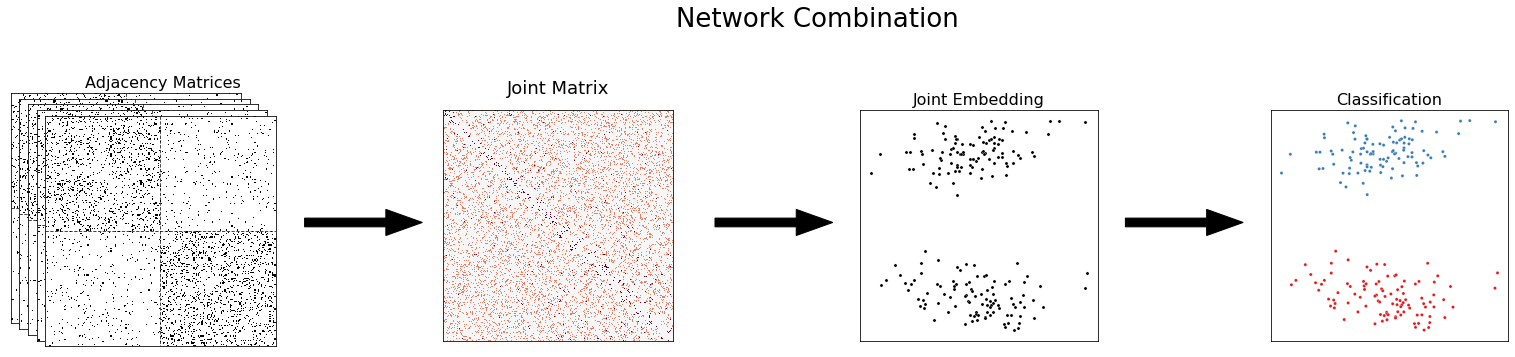

In [11]:
fig = plt.figure()

# add stack of heatmaps
for i in range(5):
    ax = fig.add_axes([.02*i, -.02*i, .8, .8]) 
    ax = binary_heatmap(normals[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="right", fontsize=16)
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)


# add arrow
arrow_ax = fig.add_axes([.8, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add joint matrix
omni_ax = fig.add_axes([1, -.02*3, .8, .8])
A = _get_omni_matrix(normals+abnormals)
a_hm = heatmap(A, ax=omni_ax, title="Joint Matrix", cbar=False)
for _, spine in a_hm.spines.items():
    spine.set_visible(True)
    
# add second arrow
arrow_ax = fig.add_axes([1.75, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add omni embedding
latents_omni = OMNI(n_components=2).fit_transform(normals+abnormals).mean(axis=0)
omni_embed_ax = fig.add_axes([2.1, -.02*3, .55, .8])
plot_latents(latents_omni, ax=omni_embed_ax, title="Joint Embedding", 
             fontdict={'fontsize': 16})
rm_ticks(omni_embed_ax, top=False, right=False)

# add third arrow
arrow_ax = fig.add_axes([2.7, .3, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# classify
labels_normal = GMM(n_components=2).fit_predict(latents_normal)
mase_ax = fig.add_axes([3.05, -.02*3, .55, .8])
plot_latents(latents_omni, ax=mase_ax, title="Classification", 
             fontdict={'fontsize': 16}, labels=labels_normal)

plt.suptitle("Network Combination", x=2, y=1.1, fontsize=26);

### Embedding product

The final approach to multigraph representation learning that we'll talk about is the Embedding Product approach. With this approach, you first embed all of your networks separately, either with Adjacency Spectral Embedding or with some other single-network embedding method. Then, you combine those embeddings and classify the result. Multiple Adjacency Spectral Embedding, another algorithm we'll be learning about later in this chapter, is an example of the Embedding Product approach.

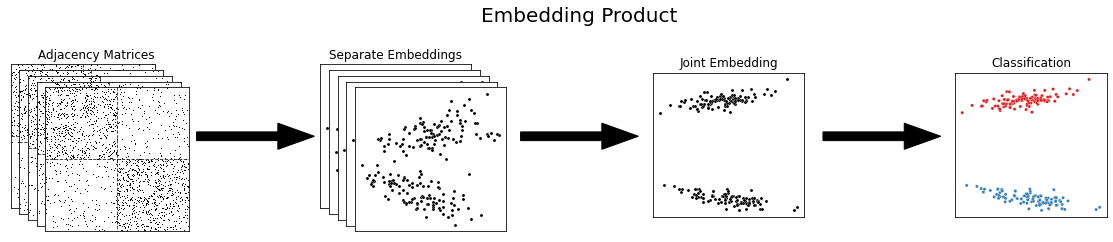

In [12]:
fig = plt.figure()

# add stack of heatmaps
for i in range(5):
    ax = fig.add_axes([.02*i, -.02*i, .5, .5]) 
    ax = binary_heatmap(normals[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Adjacency Matrices", loc="right")
    rm_ticks(ax, top=False, right=False)
    ax.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    ax.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)

# add arrow
arrow_ax = fig.add_axes([.5, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add stack of latent plots
for i in range(5):
    ax = fig.add_axes([.8+.02*i, -.02*i, .35, .5])
    if i == 0:
        ax.set_title("Separate Embeddings")
    latents = ase.fit_transform(normals[i])
    plot = sns.scatterplot(latents[:, 0], latents[:, 1], 
                       s=10, ax=ax, color="black")
    rm_ticks(ax, top=False, right=False)
    
# add second arrow
arrow_ax = fig.add_axes([1.25, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# add group embeddings
mase = MASE(n_components=2)
latents_mase = mase.fit_transform(normals + abnormals)
mase_ax = fig.add_axes([1.57, -.03, .35, .5])
plot_latents(latents_mase, ax=mase_ax, title="Joint Embedding")
rm_ticks(mase_ax, top=False, right=False)

# add third arrow
arrow_ax = fig.add_axes([1.95, .2, .3, .1])
rm_ticks(arrow_ax, left=True, bottom=True)
plt.arrow(x=0, y=0, dx=1, dy=0, width=.1, color="black") 

# classify
labels_normal = GMM(n_components=2).fit_predict(latents_normal)
mase_ax = fig.add_axes([2.27, -.03, .35, .5])
plot_latents(latents_mase, ax=mase_ax, title="Classification", 
             labels=labels_normal)

plt.suptitle("Embedding Product", x=1.4, y=.7, fontsize=20);

For the rest of this section, we'll explore the strengths and weaknesses of different particular algorithms that use these approaches. Multiple Adjacency Spectral Embedding (MASE) is an Embedding Product technique which embeds a bunch of networks separately (with normal Adjacency Spectral Embedding), and then re-embeds all the separate latent positions into a single space. MASE is nice because you don't actually need each network to be generated from the same distribution - you only need the nodes of the different networks to be aligned and for them to belong to the same communities. Omnibus embedding combines the adjacency matrix of all of the matrices into a single super-matrix, and then embeds that super-matrix.

## Multiple Adjacency Spectral Embedding

The first algorithm we'll explore is called MASE, and is probably the easiest to understand if you know how Adjacency Spectral Embeddings work. Say you have some number of networks, and (like we said above) their nodes are aligned. The goal of MASE is to embed the networks into a single space, with each point in that space representing a single node - but, unlike simply averaging, MASE lets you use networks which aren't necessarily drawn from the same distribution. MASE is based on the common subspace independent-edge (COSIE) model from the multi-network models section of chapter 5, so we're operating under the assumption that there *is* some low-dimensional space common to all of our networks that we can embed into in the first place.

Let's go back to our group of normal and abnormal brains and try using MASE to embed them rather than averaging. Then, we'll dive deeper into what's going on under the hood. First, we'll instantiate a MASE classifier and embed down to two dimensions. Then we'll create a combined list of the normal and abnormal brains, and use MASE to find the latent positions.

In [13]:
from graspologic.embed import MultipleASE as MASE

# Use MASE to embed everything
mase = MASE(n_components=2)
latents_mase = mase.fit_transform(normals + abnormals)

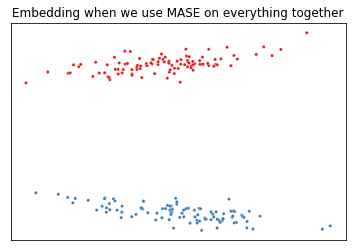

In [14]:
plot_latents(latents_mase, title="Embedding when we use MASE on everything together", labels=labels);

Unlike simply averaging all of our networks together, MASE manages to keep the community structure that we found when we averaged the normal and abnormal networks separately. Let's see what's under the hood.

### What's Going On Under The Hood

The figure below shows how MASE works. First, we embed the adjacency matrices of a bunch of networks separately, using our standard Adjacency Spectral Embedding algorithm. Then, we take all of those embeddings, concatenate them into a single matrix, and embed the entire concatenated matrix.

```{figure} ../../Images/mase1.jpeg
---
height: 400px
name: mase-fig
---
The MASE algorithm
```

#### A Collection of Networks

Suppose we have a set of networks generated from Stochastic Block Models with two communities in each network. The networks have aligned nodes -- meaning that the $i_{th}$ row of all of their adjacency matrices represent the same nodes. The nodes also all belong to the same communities. However, edge probabilities might change depending on the network. In the first network, you might have nodes in the same community having a high chance of connecting to each other, whereas in the second network, nodes are much more likely to be connected to other nodes in different communities. You want to end up with a classification that distinctly groups the nodes into their respective communities, using the information from all of the networks. Because MASE takes the Embedding Product approach, we start by embedding each network separately with an Adjacency Spectral Embedding.

Below is Python code which generates four networks with Stochastic Block Models. The labels are the same across the networks (which means that nodes have a consistent community no matter which network you're looking at), but the block probability matrices are quite different.

In [15]:
import numpy as np
from graspologic.simulations import sbm

n = 100
p1, p2, p3 = .12, .06, .03
A1, labels = make_network(p1, p3, p3, p1, 
                      return_labels=True)
A2 = make_network(p1, p3, p3, p2)
A3 = make_network(p3, p2, p2, p3)
A4 = make_network(p1, p3, p3, p3)

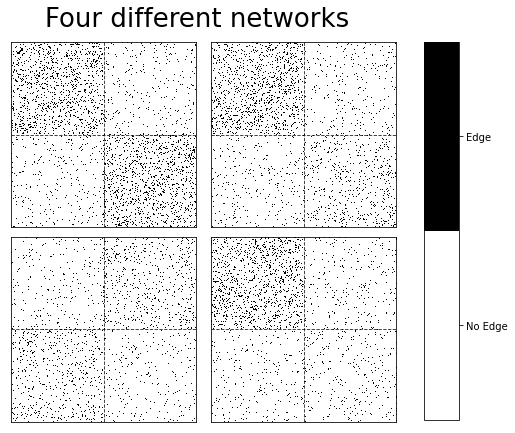

In [16]:
from graspologic.plot import binary_heatmap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


fig, axs = plt.subplots(2, 2, figsize=(7,7))
for ax, graph in zip(axs.flat, [A1, A2, A3, A4]):
    hmap = binary_heatmap(graph, ax=ax, cbar=False)
    for spine in ax.spines.values():
        spine.set_visible(True)
    hmap.vlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    hmap.hlines(n, 0, n*2, colors="black", lw=.9, linestyle="dashed", alpha=.8)
    
plt.suptitle("Four different networks", fontsize=26, y=.95)
fig.subplots_adjust(hspace=.05, wspace=.05)

cmap = ListedColormap(["white", "black"])
cbar_ax = fig.add_axes([.95, 0.13, 0.07, 0.75])
cbar = fig.colorbar(hmap.imshow(A1, cmap=cmap), cax=cbar_ax)
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(["No Edge", "Edge"])

#### Embedding

Now, we'll embed each of the four networks separately using Adjacency Spectral Embedding. We'll need these embeddings to unify the networks all into a single space.

In [17]:
from graspologic.embed import AdjacencySpectralEmbed as ASE

networks = [A1, A2, A3, A4]
latents = []
for network in networks:
    ase = ASE(n_components=2)
    latent = ase.fit_transform(network)
    latents.append(latent)

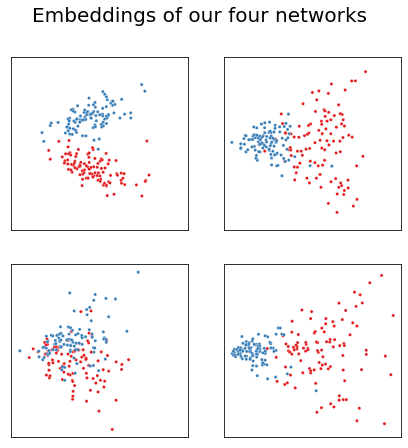

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(7,7), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    plot_latents(latents[i], title=None, labels=labels, ax=ax)
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.suptitle("Embeddings of our four networks", fontsize=20);

# TODO: add legend

Now, we want to take these individual embeddings, concatenate them into a single matrix, and then embed the result.

In [19]:
from graspologic.embed import selectSVD

concatenated = np.hstack(latents)
joint_embedding, *_ = selectSVD(concatenated, n_components=2)

<AxesSubplot:title={'center':'Joint embedding of our four networks'}>

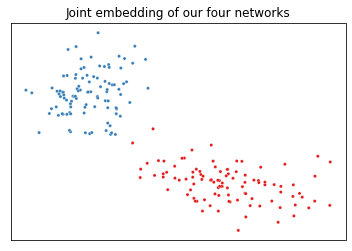

In [20]:
plot_latents(joint_embedding, title="Joint embedding of our four networks",
             labels=labels)

### *The Mathematics of MASE

With MASE, each network has a corresponding score matrix. Just like the set of joint latent positions describes how the networks are similar, the score matrices describe how each network is different.

Suppose we have a set of networks with adjacency matrices $A^{(1)}, ..., A^{(m)}$, with each network being unweighted. Suppose our joint latent positions are called $V$. Then each adjacency matrix, $A^{(i)}$, can be decomposed into $VR^{(i)} V^\top$, where $R^{(i)}$ is the score matrix corresponding to the $i_{th}$ network:

\begin{align*}
    A^{(i)} = VR^{(i)} V^\top
\end{align*}

Any particular score matrix, $R^{(i)}$, is square and $d \times d$. The dimension, $d$, corresponds to the number of embedding dimensions -- so if we wanted to embed down to two dimensions, each $R^{(i)}$ would be a $2 \times 2$ matrix. 

Now, here's the interesting part: how do we find our score matrices? Well, there's a theorem in linear algebra about matrices which are *orthogonal*, meaning that they're all perpendicular to each other. This theorem says that the inverse of an orthogonal matrix is its transpose. So, for an orthogonal matrix $O$,

\begin{align*}
    O^\top = O^{-1}
\end{align*}

Interestingly, the column-vectors of our joint embedding matrix (let's call it $V$) are all orthogonal. Since definitionally, what it means for two vectors to be orthogonal is that they have a dot product of 0, we can check this below:

In [21]:
V = joint_embedding.copy()

# Take the dot product of the columns of our joint latent position matrix
np.round(V[:, 0] @ V[:, 1])

-0.0

What this all means is that the inverse of our joint embedding matrix $V$ is its transpose. You can see below that $V^\top V$ is just the identity matrix.

In [22]:
np.round(V.T@V)

array([[1., 0.],
       [0., 1.]])

and so, finally, we can use the above two facts to find a score matrix. We just take matrix inverses, and then use the fact that the matrices we're inverting are orthogonal to turn them into transposes.

\begin{align*}
    A^{(i)} &= VR^{(i)} V^\top \\
    V^{-1} A^{(i)} (V^\top)^{-1} &= R^{(i)} \\
    V^\top A^{(i)} V &= R^{(i)} 
\end{align*}

Below, we turn our list of networks into a 3-D numpy array, and then do the above multiplication to get a new 3D numpy array of scores matrices. Because we embedded into two dimensions, each score matrix is $2 \times 2$, and the four score matrices are "slices" along the 0th axis of the numpy array.

In [23]:
networks_array = np.asarray(networks)
scores = V.T @ networks_array @ V
scores.shape

(4, 2, 2)

Now, let's recreate the first network using only its score matrix and the joint latent positions.

In [24]:
A_0 = V @ scores[0] @ V.T

In [25]:
p1, p2, p3 = .12, .06, .03
A1, labels = make_network(p1, p3, p3, p1, 
                      return_labels=True)

Below to the left, you can see the heatmap for the first network's score matrix. Next to it, you can see the recreation of the first network. Remember that we only used the score matrix to recreate it. The first network has a block probability matrix of

\begin{align}
\begin{bmatrix}
.12 & .03 \\
.03 & .06 \\
\end{bmatrix}
\end{align}

and so we should expect the edges in the top-left block of our adjacency matrix to be more connected, the edges in the two off-diagonal blocks to not be very connected, and the edges in the bottom-right block to be kind of connected.

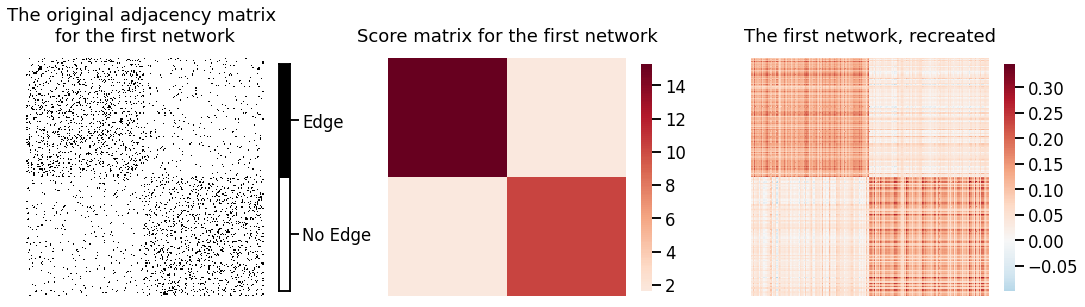

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

binary_heatmap(networks[0], title="The original adjacency matrix \nfor the first network", ax=axs[0])
heatmap(scores[0], title="Score matrix for the first network", ax=axs[1])
heatmap(A_0, title="The first network, recreated", ax=axs[2])

plt.tight_layout()

### Using Graspologic

<AxesSubplot:title={'center':'MASE embedding'}>

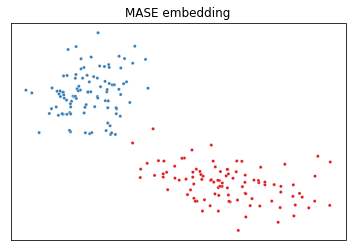

In [27]:
from graspologic.embed import MultipleASE as MASE

mase = MASE(n_components=2)
latents = mase.fit_transform(networks)

plot_latents(latents, title="MASE embedding", labels=labels)

## Omnibus Embedding